---
# PV Power Generation during Extreme Days
---
This notebook provides an analysis of how much power is generated by extreme days.

Copyright (c) 2023, ETH Zurich, Guillaume Senger

In [1]:
import my_functions
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import matplotlib.ticker as ticker
from gsee.climatedata_interface.interface import run_interface_from_dataset
import matplotlib.ticker as mtick
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

plt.rcParams['font.size'] = '24'   
mpl.rcParams['lines.linewidth'] = 2.0  

def plus_formatter_perc(x, pos): # Used for the axis label format later
    if x == 0:
        return '0'
    if x > 0:
        return '+{:.0f}%'.format(x)
    if x < 0:
        return '{:.0f}%'.format(x)

---
## Load data and compute PV power for extreme days

We load the rsds data and compute the PV power generation by different percentile days for 3 different configuations.

In [2]:
model_name    = 'GFDL-ESM4'    # Choose model of interest
location      = 'Zurich'       # Choose location of interst

rsds_models   = pickle.load(open(f'Data/rsds/{location}.pickle', 'rb')) # Load data created using the script Get_Data_Local.py
rsds = rsds_models[model_name]  # Select data from the specified model

reshaped_rsds = my_functions.reshape(rsds) # Reshape time series to the format Nx365 

# Define 3 configurations of interest for PV systems  
configs       = {0: {'tilt': 35, 'azim': 180, 'tracking': 0, 'alpha': 1  ,'linestyle': '-'     , 'label': 'South and normal tilt'},  # Configuration 0 details
                 1: {'tilt': 55, 'azim': 180, 'tracking': 0, 'alpha': 0.5,'linestyle': '--'    , 'label': 'South and strong tilt'},  # Configuration 1 details
                 2: {'tilt': 35, 'azim': 180, 'tracking': 2, 'alpha': 0.2,'linestyle': 'dotted', 'label': 'Fully tracking'       }}  # Configuration 2 details

percentiles   = [5, 50, 95]  # Choose percentiles for days of interest: 50 = normal day, 5 and 95 are extreme days

pv_powers     = {percentile: {} for percentile in percentiles}  # Dictionary to store PV powers for different percentiles

for num_config, config_details in configs.items(): # Loop through each configuration and percentile to calculate PV power

    for percentile in percentiles:

        print(f'Configuration {num_config} and percentile {percentile}')

        pv_powers[percentile][num_config] = my_functions.get_PV_one_year(
            data     = np.percentile(reshaped_rsds, percentile, axis=0),  # Compute data for the percentile
            location = location, 
            tilt     = config_details['tilt'], 
            azim     = config_details['azim'], 
            tracking = config_details['tracking']
        )

Configuration 0 and percentile 5
> Detected frequency: D
Parallel mode: 48 cores
	[=========================================================================>>] 100%
Computation part took: 3.78 seconds
Configuration 0 and percentile 50
> Detected frequency: D
Parallel mode: 48 cores
	[=========================================================================>>] 100%
Computation part took: 3.3 seconds
Configuration 0 and percentile 95
> Detected frequency: D
Parallel mode: 48 cores
	[=========================================================================>>] 100%
Computation part took: 3.14 seconds
Configuration 1 and percentile 5
> Detected frequency: D
Parallel mode: 48 cores
	[=========================================================================>>] 100%
Computation part took: 3.3 seconds
Configuration 1 and percentile 50
> Detected frequency: D
Parallel mode: 48 cores
	[=========================================================================>>] 100%
Computation part took: 3.29 se

---
## Results Visualisation

We show how much power is generated for all configurations and percentiles.

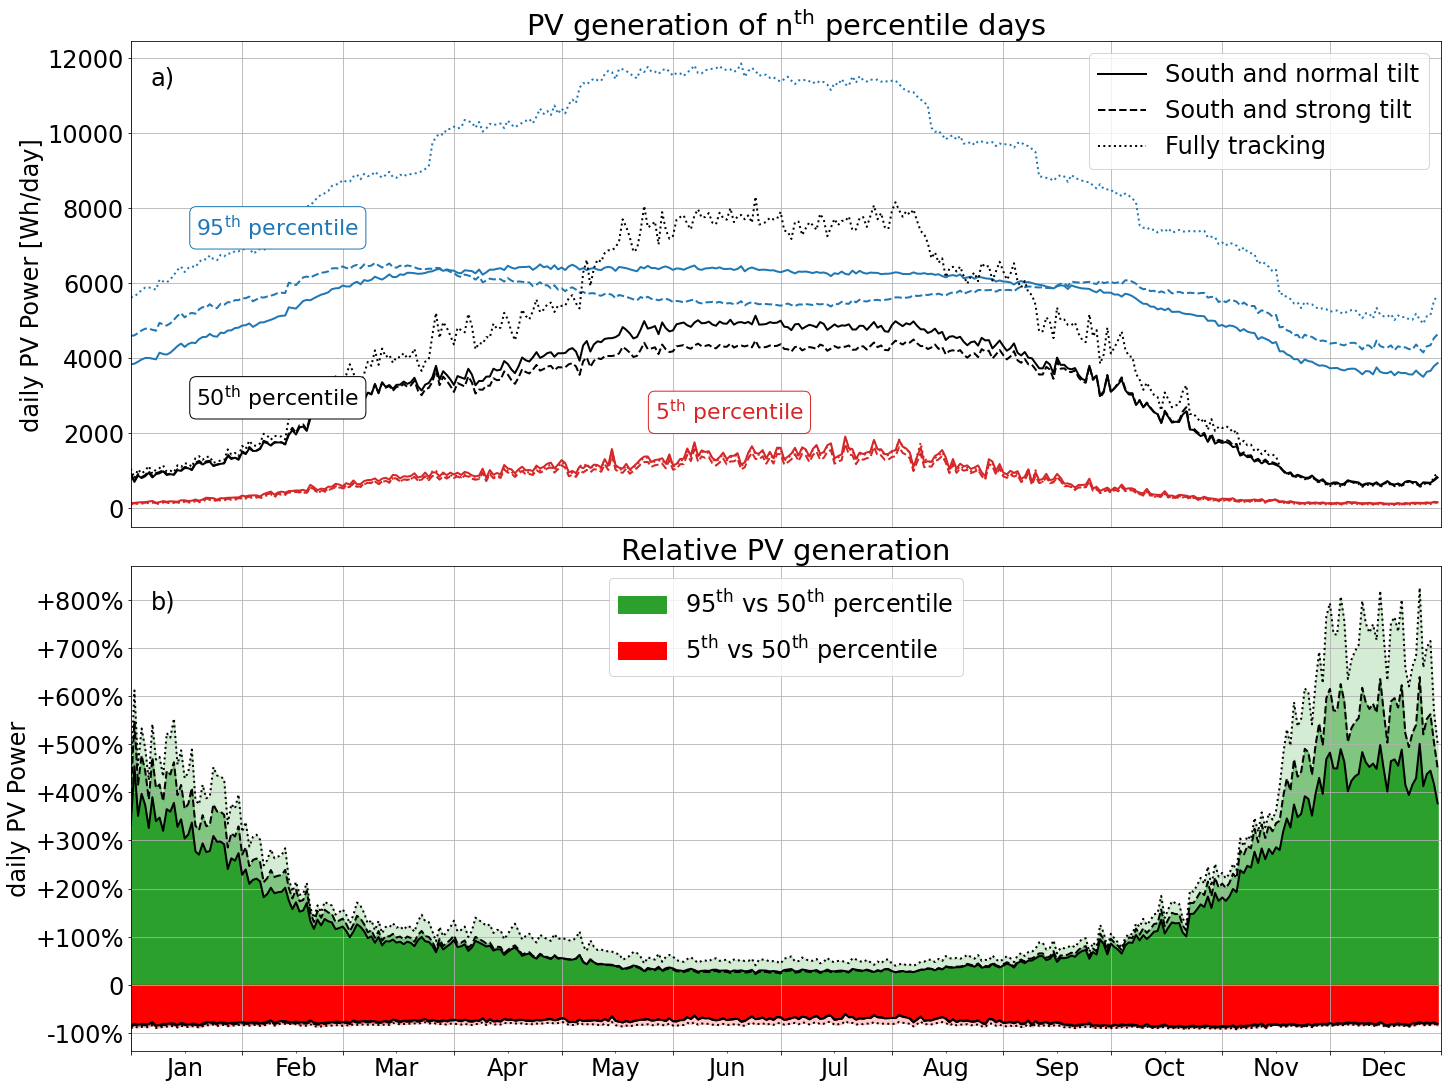

In [6]:
x = np.linspace(0,364,365)


fig = plt.figure(figsize = (20,15), constrained_layout=True)

gs = fig.add_gridspec(2, 1, height_ratios = (1, 1))

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.set_title('PV generation of n$^\mathrm{th}$ percentile days')
ax2.set_title('Relative PV generation')

for num_config, config_details in configs.items():

    # Get the plot details for the specific configuration
    alpha     = config_details['alpha']
    linestyle = config_details['linestyle']
    label     = config_details['label']

    # Get the absolute PV power generation
    pv_power_5   = pv_powers[5][num_config]
    pv_power_50  = pv_powers[50][num_config]
    pv_power_95  = pv_powers[95][num_config]

    # Plot the absolute PV power generation
    ax1.plot(pv_power_95, color = 'tab:blue', linestyle = linestyle)
    ax1.plot(pv_power_50, color = 'black'   , linestyle = linestyle,label = label)
    ax1.plot(pv_power_5 , color = 'tab:red' , linestyle = linestyle)

    # Get the relative PV power generation
    relative_diff_95_vs_50 = (pv_power_95 - pv_power_50) / pv_power_50 *100
    relative_diff_5_vs_50  = (pv_power_5  - pv_power_50) / pv_power_50 *100

    # Plot the relative PV power generation
    if num_config == 0:
        ax2.fill_between(x = x, y1 = 0, y2 = relative_diff_95_vs_50, color = 'tab:green', alpha = alpha, label = '95$^\mathrm{th}$ vs 50$^\mathrm{th}$ percentile')
        ax2.fill_between(x = x, y1 = 0, y2 = relative_diff_5_vs_50 , color = 'red'      , alpha = alpha, label = '5$^\mathrm{th}$ vs 50$^\mathrm{th}$ percentile' )
    else:
        ax2.fill_between(x = x, y1 = 0, y2 = relative_diff_95_vs_50, color = 'tab:green', alpha = alpha)
        ax2.fill_between(x = x, y1 = 0, y2 = relative_diff_5_vs_50 , color = 'red'      , alpha = alpha)

    ax2.plot(relative_diff_95_vs_50, color = 'k', linestyle = linestyle)    
    ax2.plot(relative_diff_5_vs_50 , color = 'k', linestyle = linestyle)


ax1.text(0.015, 0.95, 'a)', transform=ax1.transAxes, va='top')
ax2.text(0.015, 0.95, 'b)', transform=ax2.transAxes, va='top')

for ax in [ax1, ax2]:
    ax.grid()
    ax.set_xlim(0,364)
    ax.set_xticks([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365])

ax1.legend()
ax2.legend(loc = 'upper center')

ax1.set_ylabel('daily PV Power [Wh/day]')
ax2.set_ylabel('daily PV Power')

ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)


# Set the format for the ticks labels
yticks_plus_perc = mtick.FuncFormatter(plus_formatter_perc)
ax2.yaxis.set_major_formatter(yticks_plus_perc)

ax2.set_yticks([-100, 0, 100, 200, 300, 400, 500, 600, 700, 800])

ax2.set_xticklabels('')
ax2.set_xticks([15, 46, 74, 105, 135, 166, 196, 227, 258, 288, 319, 349], minor=True)
ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], minor=True)

ax1.text(0.05, 0.6, '$95^{\mathrm{th}}$ percentile', color = 'tab:blue', transform=ax1.transAxes, bbox=dict(facecolor='white', edgecolor='tab:blue', boxstyle='round'), fontsize = 22)
ax1.text(0.05, 0.25, '$50^{\mathrm{th}}$ percentile', transform=ax1.transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), fontsize = 22)
ax1.text(0.4, 0.22, '$5^{\mathrm{th}}$ percentile', color = 'tab:red',transform=ax1.transAxes, bbox=dict(facecolor='white', edgecolor='tab:red', boxstyle='round'), fontsize = 22)

plt.savefig(f'Figures/PV_Analysis/Extreme_days.png', bbox_inches='tight')

plt.show()